In [3]:
# Modules to import

!pip install --user nipy
!pip install --user nilearn
!pip install --user seaborn
!pip install --user keras
!pip install --user SimpleITK

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 42.5MB 11.3MB/s eta 0:00:01   |██▌                             | 3.3MB 3.1MB/s eta 0:00:13     |█████████████████████▉          | 29.1MB 10.5MB/s eta 0:00:02
You should consider upgrading via the 'pip install --upgrade pip' command.


In [84]:
!pip install --user numba
from numba import cuda
cuda.select_device(0)
cuda.close()
from keras import backend as K
K.clear_session()

     |████████████████████████████████| 3.6MB 2.7MB/s eta 0:00:01     |██████████▉                     | 1.2MB 614kB/s eta 0:00:04     |███████████████████████████████▍| 3.5MB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 20.2MB 3.3MB/s eta 0:00:01    |█████████▍                      | 5.9MB 5.4MB/s eta 0:00:03     |████████████████████████        | 15.1MB 2.9MB/s eta 0:00:02     |████████████████████████▎       | 15.3MB 2.9MB/s eta 0:00:02     |██████████████████████████      | 16.3MB 2.9MB/s eta 0:00:02     |██████████████████████████████▍ | 19.2MB 3.3MB/s eta 0:00:01     |██████████████████████████████▊ | 19.3MB 3.3MB/s eta 0:00:01     |███████████████████████████████▎| 19.7MB 3.3MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Main Imports

import nilearn

from nilearn.image import resample_to_img

import pylab as plt

import numpy as np
import nibabel as nb
import os
import glob
import random
import pandas as pd
import re

import seaborn as sns #added
sns.set(style="darkgrid") #added

from nilearn.image import mean_img #added
from nilearn.plotting import plot_anat #added

# Principal code parameters

In [3]:
# Local directory where the Data are mounted
rootDirectory = "/data/RMN/LUCA_PASQUINI"

# Local subdirectory where dataset is mounted
dataDir = "DATI_SEGMENTATI_SCALATI_media"

# Dataset dir
datasetDir = f"{rootDirectory}/{dataDir}"

#CSV fileroot 
fileName = f"{rootDirectory}/{dataDir}/Array_Labels_Def.csv"

SUBJECT_NAME_REPEATED=["BIANCHI","BOVE","PROIETTI"]

#for i in range(len(SUBJECT_NAME_REPEATED)):
#    f"{SUBJECT_NAME_REPEATED[i]}"
#    print(f"{SUBJECT_NAME_REPEATED[i]}")

PATIENT_REMOVED=['Pascal','Mitchell','Rufini','Farella','Array']

SEQUENCE_1= "FLAIR_registered"
#SEQUENCE_2= "rCBV"
#T1_registered , T1
#T2_registered , T2
#FLAIR_registered , FLAIR
#ADC_registered , ADC
#rCBV_registered , rCBV
#MPRAGEMDC
MaskPath = "T2ROI"
#SOLID
#NECROSI
#T1ROI
#T2ROI


#reference dimensions
#dim1=128
#dim2=128
#dim3=14


# Survival Labels dataframe

In [4]:
#CSV fileroot 
#fileName = "/data/RMN/LUCA_PASQUINI/DATI_SEGMENTATI_SCALATI_media/Array_Labels_Def.csv"

#csv file
df = pd.read_csv(fileName, sep=";", header=None)

#Dataframe columns title
df.columns = ["Subject", "Survival"]

#Subject column as index
df = df.set_index('Subject')

#in order to check the entire dataframe of labels
pd.set_option('display.max_rows', len(df))
print(df)

                Survival
Subject                 
Alessandrini           0
Angeloni               1
Assanto                0
Asta                   1
Bagnoli                1
Balzamo                1
Barontini              0
Battista               1
Bergnach               1
Bernola                0
Bertuzzi               0
Bevilacqua             0
BianchiG               0
BianchiO               0
BianchiS               1
Biavati                0
Boezi                  1
BoveA                  0
Cacace                 1
Caldaroni              1
Camacci                0
Camplese               1
Capezzone              0
Carulli                1
Carzedda               0
Catalani               0
Cellini                0
Cherri                 1
Cimpureanu             1
Colafrancesco          0
Colamartini            0
Colazzo                0
Coletta                1
Cosimi                 1
Costanzi               1
Crescenzi              0
Darida                 0
BoveP                  1


# Functions

In [5]:
#NORMALIZE_NAME: the function takes the subject path basename and splits it according to the underscore
#in order to take the first string and use it as index in dataframe.
#If a string is repeated, the function adds the first letter of the second string after the underscore

def normalize_name(subject_path, add_name):
    #Components= []
    subject = os.path.basename(subject_path)
    subject = re.sub(r'^(DE|D|DI|LO|DEL)_', '', subject)
    components =  subject.split("_")
    if add_name[0]==components[0] or add_name[1]==components[0] or add_name[2]==components[0] :
            return components[0].title() + components[1][0].capitalize()
    else:
            return components[0].title()
        
    
#GET_SUBJECT_METADATA:the function recives, as input, the subject path and the list of name repeated already known
#the output are the path base name (SURNAME_NAME) and the normalized name
#add_name needs to contain the list of name repeated


def get_subject_metadata(subject_path, subjects_with_name=[]):
    dirname = os.path.basename(subject_path)
    return (dirname, normalize_name(subject_path, add_name=[name for name in subjects_with_name]))

In [6]:
'''' Get index positions of value in dataframe '''
def getIndexes(dfObj, value):
    listOfPos = list()
    result = dfObj.isin([value]) # Get bool dataframe with True at positions where the given value exists
    seriesObj = result.any() # Get list of columns that contains the value
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames: # Iterate over list of columns and fetch the rows indexes where value exists
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
# Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

In [7]:
def ReboundwithMask(Seq_mask_conv):
    r = np.any(Seq_mask_conv, axis=(1, 2))
    c = np.any(Seq_mask_conv, axis=(0, 2))
    z = np.any(Seq_mask_conv, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    #print(rmin,rmax,cmin,cmax,zmin,zmax)
    
    delta_r=rmax-rmin
    delta_c=cmax-cmin
    delta_z=zmax-zmin
    
    delta_max=np.amax([delta_r,delta_c,delta_z])
    
    Rebounded_Sequence=Seq_mask_conv[rmin:(rmin+delta_max),cmin:(cmin+delta_max),zmin:(zmin+delta_max)]
    
    return Rebounded_Sequence

In [8]:
# mask: f"{datasetDir}/{Path}/ROI/{MaskPath}.nii.gz"
# sequence: f"{datasetDir}/{Path}/{SEQUENCE_1}.nii"
def BrainBox(Mask_file, Sequence_file):
    
    mask_data = nb.load(Mask_file)
    Mask = np.asarray(mask_data.dataobj)
    
    r = np.any(Mask, axis=(1, 2))
    c = np.any(Mask, axis=(0, 2))
    z = np.any(Mask, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    #f"{Path}"
    #for i in range(3):
    #    if Mask.shape[i]==Sequence.shape[i] :
    #    print("All Elements in List are Equal")
    #else:        
    #    print(f"All Elements in {Path} are Not Equal")
    
    delta_r=rmax-rmin
    delta_c=cmax-cmin
    delta_z=zmax-zmin
    delta_max=np.amax([delta_r,delta_c,delta_z])
    
    # Load bounding boxed image
    sequence_data = nb.load(Sequence_file)
    
    # Apply bounding box
    return sequence_data.dataobj[(rmin):((rmin)+delta_max),(cmin):((cmin)+delta_max),(zmin):((zmin)+delta_max)]
    
    # Sequence=np.asarray(sequence_data.get_fdata())
    # Dim=[Sequence.shape]

    # BrainBox_Sequence=Sequence[(rmin):((rmin)+delta_max),(cmin):((cmin)+delta_max),(zmin):((zmin)+delta_max)]
    # return BrainBox_Sequence

In [9]:
def PercentileSlicer(sequence_mask,brain_box,length,percentile,affine):
    for i in range(length):
        seq_sizes=np.sum(sequence_mask,axis=(0,1))
        non_empty_sizes = seq_sizes[np.where(seq_sizes > 0)]
        percentile_val = np.percentile(non_empty_sizes, percentile)
        seq_indexes = np.where(seq_sizes > percentile_val)[0]
    
    return np.asarray([brain_box[:,:,k] for k in seq_indexes])
    
    
    
        

# Dataframe folders construction

In [10]:
#Path and Subject columns
Df_Subjects_dirs = pd.DataFrame()
for subject_path in glob.glob(f"{datasetDir}/*"):
    subjects_dirs=[get_subject_metadata(subject_path , subjects_with_name=[SUBJECT_NAME for SUBJECT_NAME in SUBJECT_NAME_REPEATED])]
    print(subjects_dirs)
    df_subject_dirs = pd.DataFrame(subjects_dirs,columns=["Path", "Subject"])
    Df_Subjects_dirs=pd.concat([Df_Subjects_dirs,df_subject_dirs],ignore_index=True)


#in order to check the correct constucrion of 
pd.set_option('display.max_rows', len(Df_Subjects_dirs))
print(Df_Subjects_dirs)

#Subject as index
Df_Subjects_dirs = Df_Subjects_dirs.set_index('Subject')
pd.set_option('display.max_rows', len(Df_Subjects_dirs))

#in order to check the correct constucrion of Df_Subjects_dirs
print(Df_Subjects_dirs)

#Unnecessary strings removal with "drop" function
x=Df_Subjects_dirs
x.drop(index='Array', columns='Path')
# Delete rows with index label a & b    
modX= x.drop([PATIENT for PATIENT in PATIENT_REMOVED])
#modX["Path"]
modX = pd.DataFrame(modX)

#in order to check the correct construction of the dataframe
pd.set_option('display.max_rows', len(modX))
print(modX)

[('ALESSANDRINI_GLAUCO', 'Alessandrini')]
[('ANGELONI_GIUSEPPINA', 'Angeloni')]
[('Array_Labels_Def.csv', 'Array')]
[('ASSANTO_MARIA', 'Assanto')]
[('ASTA_G', 'Asta')]
[('BAGNOLI_VINCENZO', 'Bagnoli')]
[('BALZAMO_A', 'Balzamo')]
[('BARONTINI_MARIA_GIOVANNA', 'Barontini')]
[('BATTISTA_DOMENICA', 'Battista')]
[('BERGNACH_SILVANO', 'Bergnach')]
[('BERNOLA_TERESA', 'Bernola')]
[('BERTUZZI_LUISA', 'Bertuzzi')]
[('BEVILACQUA_RITA', 'Bevilacqua')]
[('BIANCHI_GIOVANNI', 'BianchiG')]
[('BIANCHI_ORAZIO', 'BianchiO')]
[('BIANCHI_S', 'BianchiS')]
[('BIAVATI_S', 'Biavati')]
[('BOEZI_MARIO', 'Boezi')]
[('BOVE_A', 'BoveA')]
[('CACACE_PAOLO', 'Cacace')]
[('CALDARONI_ANNA', 'Caldaroni')]
[('CAMACCI_FILIBERTO', 'Camacci')]
[('CAMPLESE_CANDEROLA', 'Camplese')]
[('CAPEZZONE', 'Capezzone')]
[('CARULLI_L', 'Carulli')]
[('CARZEDDA_PAOLO', 'Carzedda')]
[('CATALANI_F', 'Catalani')]
[('CELLINI_T', 'Cellini')]
[('CHERRI_M', 'Cherri')]
[('CIMPUREANU_N', 'Cimpureanu')]
[('COLAFRANCESCO_ROCCO', 'Colafrancesco')]
[(

Zeppa                           ZEPPA_ONORIO


# Join function between Path and Labels

In [11]:
result = modX.join(df, on='Subject')

#in order to check if all the dataframe is construced in the right way
pd.set_option('display.max_rows', len(result))
result   

,Path,Survival
Subject,,
Alessandrini,ALESSANDRINI_GLAUCO,0.0
Angeloni,ANGELONI_GIUSEPPINA,1.0
Assanto,ASSANTO_MARIA,0.0
Asta,ASTA_G,1.0
Bagnoli,BAGNOLI_VINCENZO,1.0
Balzamo,BALZAMO_A,1.0
Barontini,BARONTINI_MARIA_GIOVANNA,0.0
Battista,BATTISTA_DOMENICA,1.0
Bergnach,BERGNACH_SILVANO,1.0


# NAN removal

In [12]:
#it takes the indexes to which the NaN corresponds
NAN_index=result['Survival'].index[result['Survival'].apply(np.isnan)]

#it takes the number of the corresponding row as int
df_index=result.index.values.tolist()
int_index=[df_index.index(i) for i in NAN_index]
#int_index

#than it is possible to obtain the corresponding survival label of the original array, df in this case
label=[df.iloc[x]['Survival'] for x in int_index]
label

#iteration to replace the NaNs
for l in label:
    result['Survival'].fillna(l,inplace=True)
    
#result is the final Dataframe with "Subject" as index and the columns "Path" and "Survival"
pd.set_option('display.max_rows', len(result))
result

,Path,Survival
Subject,,
Alessandrini,ALESSANDRINI_GLAUCO,0.0
Angeloni,ANGELONI_GIUSEPPINA,1.0
Assanto,ASSANTO_MARIA,0.0
Asta,ASTA_G,1.0
Bagnoli,BAGNOLI_VINCENZO,1.0
Balzamo,BALZAMO_A,1.0
Barontini,BARONTINI_MARIA_GIOVANNA,0.0
Battista,BATTISTA_DOMENICA,1.0
Bergnach,BERGNACH_SILVANO,1.0


# Matrix construction

In [37]:
%time
affine=nb.load(f"{datasetDir}/ALESSANDRINI_GLAUCO/{SEQUENCE_1}.nii").affine
percentile=40
listOfElems=[] 
DIM = []
DIM_NEW = []
SEQUENCES=[] 

for Path in result["Path"]:
    if os.path.isfile(f"{datasetDir}/{Path}/{SEQUENCE_1}.nii"):
        
        sequence_data = f"{datasetDir}/{Path}/{SEQUENCE_1}.nii"
        
        mask_data = f"{datasetDir}/{Path}/ROI/{MaskPath}.nii.gz"
    
        
        Sequence=np.asarray(nb.load(sequence_data).get_fdata())
        Mask= np.asarray(nb.load(mask_data).dataobj)
        Seq_mask_conv=Sequence*Mask
        New_sequence= ReboundMask(Seq_mask_conv)
        l=len(New_sequence[0][1])
        
        BrainBox_sequence = BrainBox(mask_data, sequence_data)
        
        brain_box_reduced=PercentileSlicer(New_sequence,BrainBox_sequence,l,percentile,affine)
        brain_box_red=np.moveaxis(brain_box_reduced, 0, -1)
        
        Dim_new = [brain_box_red.shape]
        DIM_NEW.append(Dim_new)
        # DIM.append(Dim)
        
        SEQUENCES.append(brain_box_reduced)

        listOfElems.append([Path])

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 28.6 µs


In [38]:
DIM_NEW

[[(84, 105, 38)],
 [(56, 56, 10)],
 [(92, 92, 55)],
 [(60, 60, 29)],
 [(92, 92, 55)],
 [(205, 205, 87)],
 [(61, 61, 34)],
 [(93, 93, 33)],
 [(93, 93, 41)],
 [(47, 47, 20)],
 [(101, 101, 54)],
 [(42, 42, 25)],
 [(180, 183, 9)],
 [(79, 81, 42)],
 [(168, 168, 101)],
 [(92, 94, 46)],
 [(88, 88, 45)],
 [(89, 89, 38)],
 [(100, 100, 47)],
 [(85, 85, 43)],
 [(106, 106, 48)],
 [(95, 95, 48)],
 [(73, 73, 34)],
 [(187, 187, 81)],
 [(257, 260, 97)],
 [(153, 153, 92)],
 [(218, 218, 64)],
 [(102, 102, 59)],
 [(70, 70, 35)],
 [(99, 99, 41)],
 [(106, 106, 39)],
 [(77, 77, 39)],
 [(215, 215, 95)],
 [(130, 130, 53)],
 [(82, 82, 28)],
 [(79, 85, 35)],
 [(258, 258, 90)],
 [(63, 63, 28)],
 [(207, 207, 99)],
 [(51, 51, 26)],
 [(221, 221, 6)],
 [(110, 110, 44)],
 [(101, 101, 51)],
 [(221, 221, 50)],
 [(56, 56, 33)],
 [(82, 82, 11)],
 [(103, 103, 61)],
 [(50, 50, 30)],
 [(181, 181, 39)],
 [(90, 90, 39)],
 [(84, 84, 34)],
 [(84, 87, 36)],
 [(106, 106, 34)],
 [(78, 78, 40)],
 [(202, 202, 101)],
 [(80, 80, 39)],

In [39]:
K=[]
J=[]
L=[]
for i in range(len(DIM_NEW)):
    k=DIM_NEW[i][0][0]
    K.append(k)
    
for i in range(len(DIM_NEW)):
    j=DIM_NEW[i][0][1]
    J.append(j)
    
for i in range(len(DIM_NEW)):
    l=DIM_NEW[i][0][2]
    L.append(l)
    


In [40]:
#cerco i valori minimi sulla base dei quali fare il resample
Max_value1=min(K)
Max_value3=max(L)

import statistics
Mean_value1=int(statistics.mean(K))

Mean_value3=int(statistics.mean(L))

print(Max_value1,Max_value3,Mean_value1,Mean_value3)


# Min_value[:,0]
# pos=np.where(Min_value[:,0]==Min[0])
# pos

36 101 105 45


In [ ]:
#DIM_NEW[:,0,1]

In [ ]:
'''not_in_index = [x for x in range(len(K)) if not np.all(DIM_NEW[x] == [(Max_value1, Max_value3, Max_value3)])]

DIM_NEW=np.asarray(DIM_NEW) 


pos_1=np.where(DIM_NEW[:,0,0]==Max_value1) #position with first dimension equal to 192
pos_2=np.where(DIM_NEW[:,0,1]==Max_value3) #position with first dimension equal to 256
pos_3=np.where(DIM_NEW[:,0,2]==Max_value3) #position with first dimension equal to 144
eq=np.intersect1d(pos_1,pos_2)  #that command in order to find the intersection between the pos_1 and pos_2
index_IMG=np.intersect1d(eq,pos_3) #intersection that gives the complememntary information of not_in_index

#Here is given a random position that corresponds to the dimension request
def_index=random.choice(index_IMG)
print(def_index)



len(not_in_index)'''

In [41]:
affine

array([[-9.76262808e-01, -1.33213371e-05, -2.47701239e-02,
         8.53741379e+01],
       [ 1.35874478e-02,  8.07663560e-01, -5.61929822e-01,
        -5.91547089e+01],
       [-2.00144798e-02,  5.48957109e-01,  8.26749325e-01,
        -1.46797394e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [42]:
import nibabel
BRAIN_BOXES=[]
for i in range(len(listOfElems)):
    ArraytoIMG=nibabel.Nifti1Image(SEQUENCES[i], affine=affine)
    BRAIN_BOXES.append(ArraytoIMG)   


In [21]:
BRAIN_BOXES=[]
for i in range(len(listOfElems)):
    ArraytoIMG=nilearn.image.new_img_like(sequence_data,SEQUENCES[i], affine=None, copy_header=False)
    BRAIN_BOXES.append(ArraytoIMG)   

KeyboardInterrupt: 

In [43]:
'''RESAMPLE BLOCK'''

#The resample function is executed only on images without the dimension request, respect to a random image with dimension (192,256,144)
for i in range(len(DIM_NEW)):
    Res=nilearn.image.resample_img(BRAIN_BOXES[i], target_affine=affine,target_shape=(Mean_value1, Mean_value1, Mean_value3),interpolation='nearest')
    
    SEQUENCES[i]=Res.dataobj

In [44]:
l=len(SEQUENCES)
l

148

In [ ]:
'''RESAMPLE BLOCK'''

#The resample function is executed only on images without the dimension request, respect to a random image with dimension (192,256,144)
for i in not_in_index:
    Res=nilearn.image.resample_to_img(BRAIN_BOXES[i], BRAIN_BOXES[def_index],interpolation='nearest')
    BRAIN_BOXES[i]=Res
    SEQUENCES[i]=BRAIN_BOXES[i].dataobj

In [ ]:
import pickle
pickle.dump( SEQUENCES[:], open( "FLAIR_BOXES.pickle", "wb" ) )

In [58]:
AFFINE_MATRIX=[BRAIN_BOXES[i].affine for i in range(len(BRAIN_BOXES))]

source_affine=np.asarray(AFFINE_MATRIX)  

In [59]:
source_affine_def=source_affine[0]
source_affine_def

array([[-9.76262808e-01, -1.33213371e-05, -2.47701239e-02,
         8.53741379e+01],
       [ 1.35874478e-02,  8.07663560e-01, -5.61929822e-01,
        -5.91547089e+01],
       [-2.00144798e-02,  5.48957109e-01,  8.26749325e-01,
        -1.46797394e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [47]:
def Rotation(source_affine_def,gamma,sequences):
    angle=np.pi/gamma
    rotation_matrix=np.array([[-np.cos(angle), np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
    source_affine_def[:2, :2] = rotation_matrix
    
    import nibabel
    brain_boxes_rot =[nibabel.Nifti1Image(sequences[i], affine=source_affine_def) for i in range(len(sequences))]
    sequences_rot=np.asarray([brain_boxes_rot[i].dataobj for i in range(len(brain_boxes_rot))])
    
    return sequences_rot

In [48]:
sequences_rot_15=Rotation(source_affine_def,12,SEQUENCES)


In [51]:
sequences_rot_30=Rotation(source_affine_def,6,SEQUENCES)

In [54]:
sequences_rot_45=Rotation(source_affine_def,4,SEQUENCES)

In [57]:
sequences_rot_60=Rotation(source_affine_def,3,SEQUENCES)

In [60]:
sequences_rot_90=Rotation(source_affine_def,2,SEQUENCES)

In [ ]:
sequences_rot_15.shape
sequences_rot_30.shape
sequences_rot_45.shape

In [61]:
sequences_ROT=np.asarray([sequences_rot_15,sequences_rot_30,sequences_rot_45,sequences_rot_60,sequences_rot_90])

In [62]:
sequences_ROT.shape

(5, 148, 105, 105, 45)

In [ ]:
sequences_ROT[1][:].shape

In [63]:
def MatrixConstruction(sequences,length,numb_rotation,
                      dim1,dim3,Sequences_rot):
    Input_matrix=np.empty((length*(1+numb_rotation),dim1, dim1, dim3))
    
    for i in range(length):
        Input_matrix[i,:,:,:]=sequences[i] # np.array(SEQUENCES[i])

    
    for k in range(1,numb_rotation):
        for i in range(length*k,length*(k+1)):
            for j in range(length):
                Input_matrix[i,:,:,:]=Sequences_rot[k][j]

                
    return Input_matrix
                
    
    
    
    

In [65]:
Input_matrix=MatrixConstruction(SEQUENCES,l,5,Mean_value1,Mean_value3,sequences_ROT)

In [ ]:
l=len(SEQUENCES)

In [21]:
'''Reshaping of Input Matrix'''

Input_matrix=np.empty((len(SEQUENCES),Mean_value1,Mean_value1,Mean_value3)) #in order to generate an empty array with a fixed shape

for i in range(len(SEQUENCES)):

    Input_matrix[i,:,:,:]=SEQUENCES[i]





    
    
#in order to check the correct construction    
Input_matrix.shape

#import pickle
#pickle.dump( Input_matrix, open( "Input_matrix.pickle", "wb" ) )

(148, 105, 105, 22)

In [ ]:
#Input_matrix=MatrixConstruction(SEQUENCES,l,False,0,not_in_index,index_IMG,Max_value1,Max_value3)

In [66]:
Input_matrix.shape

(888, 105, 105, 45)

In [67]:
data = Input_matrix[...,None]
Input_matrix = None

In [79]:
data=np.moveaxis(data, 1, -1)

In [68]:
data.shape

(888, 105, 105, 45, 1)

In [69]:
'''Labels Array Construction'''
import array
#the following iteration allows the extraction of indexes corresponding to the paths selected by the preavious iterations
T1_Subject=[]
for i in range(len(listOfElems)):
    Pos=getIndexes(result, listOfElems[i][0])
    print(Pos[0][0])
    T1_Subject.append(Pos[0][0])  #the T1_Subject array contains these information

#the following iteration takes the corresponding Survival information on the result Dataframe built before    
T1_Subject_array=np.asarray(T1_Subject)

T1_Labels=[]
for i in range(len(T1_Subject_array)):
    lab = result.loc[T1_Subject_array[i],"Survival"]
    T1_Labels.append(int(lab)) #creates the list that contains these information

T1_Labels=np.asarray(T1_Labels) #that's the relative array

Label_Def_1=np.append(T1_Labels,T1_Labels,axis=0)
Label_Def_2=np.append(Label_Def_1,T1_Labels,axis=0)
Label_Def_3=np.append(Label_Def_2,T1_Labels,axis=0)
Label_Def_4=np.append(Label_Def_3,T1_Labels,axis=0)
Label_Def_5=np.append(Label_Def_4,T1_Labels,axis=0)
Label_Def=Label_Def_5
#Label_Def=T1_Labels
print(Label_Def)
print(Label_Def.shape)


#Label_Def
#the following iteration allows the construction of the final labels array with doubled information of each element of T1_Labels array
#Label_Def=[]
#for x in range(len(T1_Labels)):
#    label_Def=[[T1_Labels[x]]*2]
#    Label_Def.append(label_Def)
    
#Label_Def=np.asarray(Label_Def)
#Label_Def=np.ravel(Label_Def)
#Label_Def #that's the final label array that can be used for the training

Alessandrini
Angeloni
Assanto
Asta
Bagnoli
Balzamo
Barontini
Battista
Bergnach
Bernola
Bertuzzi
Bevilacqua
BianchiG
BianchiO
Biavati
Boezi
Cacace
Caldaroni
Camacci
Camplese
Capezzone
Carulli
Carzedda
Catalani
Cellini
Cherri
Cimpureanu
Colafrancesco
Colamartini
Colazzo
Coletta
Cosimi
Costanzi
Crescenzi
Darida
BoveP
Paoli
Santis
Diaspro
Carlatonio
Lorenzo
Marco
Maso
Massa
Dobrisan
Droghei
Angeli
Angelo
Emery
Fabiani
Federico
Ferrazza
Ferri
Filipponi
Fiucci
Florio
Fratini
Gattamorta
Geggi
Gennari
Giaccherini
Gianfelici
Gioia
Giordano
Inciti
Ionta
Ismail
Isoni
Labella
Landone
Liberati
Lioce
Longo
Bello
Lupi
Maiolini
Maragno
Marcolini
Marconi
Mariani
Marocchi
Martella
Martinez
Masci
Medici
Micheli
Monacelli
Moscardini
Movia
Musat
Nerone
Nervegna
Orlandi
Pagannone
Pagliaroli
Pagnotta
Palma
Palmieri
Panetti
Pascarella
Passari
Pennicchi
Pieri
Pierini
Pineda
Pistoia
Podagrosi
Podda
Pompei
Principi
ProiettiG
ProiettiM
Quacquarelli
Quattrociocchi
Re
Ricci
Romito
Ronzo
Rosari
Ruscito
Rusnac
Russo


# TRAINING

In [70]:
'''Modules needed'''

import tensorflow as tf
from keras.models import Sequential

from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization
from tensorflow.keras import regularizers

from keras.optimizers import Adam, SGD

from keras import backend as K

In [ ]:
pip install -U scikit-learn

In [71]:
from sklearn.preprocessing import LabelEncoder

In [72]:
labels=Label_Def
le = LabelEncoder().fit(labels)
from keras.utils import to_categorical
#labels = to_categorical(labels)
labels = to_categorical(le.transform(labels), 2)
#from sklearn.preprocessing import label_binarize
#labels=sklearn.preprocessing.label_binarize(labels, [0,1])

labels.shape

(888, 2)

In [73]:
from sklearn.model_selection import train_test_split
(trainX,testX,trainY,testY)=train_test_split(data,labels,test_size=0.2,stratify=labels,random_state=42)

print(trainX.shape,testX.shape,trainY.shape,testY.shape)

(710, 105, 105, 45, 1) (178, 105, 105, 45, 1) (710, 2) (178, 2)


In [74]:
# Get shape of input data
data_shape = tuple(data.shape[1:])

print(data_shape)
# Specify shape of convolution kernel
kernel_size = (3, 3, 2)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 32  # For better results, increase this value to 8

(105, 105, 45, 1)


In [ ]:
K.clear_session()
model = Sequential()

model.add(Conv3D(filters, kernel_size, activation='relu',use_bias=True, input_shape=data_shape,
                 strides=(3, 3, 1),data_format="channels_last",kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling3D())

model.add(Conv3D(filters*2, kernel_size, activation='relu',use_bias=True,
                 strides=(3, 3, 1),data_format="channels_last",kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters*2, kernel_size, activation='relu',use_bias=True,
                 strides=(3, 3, 1),data_format="channels_last",kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

#256,1024
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#512 #2048
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

# optimizer
learning_rate = 0.0001
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate,decay=0.0001/400,momentum=0.9)

model.compile(loss='binary_crossentropy',
              optimizer=sgd, # swap out for sgd 
              metrics=['accuracy','binary_crossentropy'])

model.summary()

In [82]:
K.clear_session()
model = Sequential()

model.add(Conv3D(filters, kernel_size, activation='relu', input_shape=data_shape,data_format="channels_last",
                 strides=(2, 2, 2),kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling3D())

model.add(Conv3D(filters*2, kernel_size, activation='relu',
                 strides=(2, 2, 2),kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 1)))

model.add(Conv3D(filters*4, kernel_size, activation='relu',
                 strides=(2, 2, 2),kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 1)))

model.add(Flatten())

#256,1024
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#512 #2048
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

# optimizer
learning_rate = 0.001
adam = Adam(lr=learning_rate,amsgrad=True)
sgd = SGD(lr=learning_rate,decay=0.0001/100,momentum=0.9)

model.compile(loss='binary_crossentropy',
              optimizer=adam, # swap out for sgd 
              metrics=['accuracy','binary_crossentropy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 52, 52, 22, 32)    608       
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 52, 22, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 26, 26, 11, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 12, 5, 64)     36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 5, 64)     256       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 6, 5, 64)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 2, 2, 128)     

In [ ]:
K.clear_session()
model = Sequential()

model.add(Conv3D(filters, kernel_size, activation='relu', input_shape=data_shape,
                 strides=(3, 3, 2),data_format="channels_last"))
model.add(BatchNormalization())
model.add(MaxPooling3D())

model.add(Conv3D(filters*2 , kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters*3 , kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

#256,1024
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#512 #2048
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

# optimizer
learning_rate = 1e-5
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=adam, # swap out for sgd 
              metrics=['accuracy','binary_crossentropy'])

model.summary()

In [76]:
nEpochs = 100  # Increase this value for better results (i.e., more training)

batch_size = 16  # Increasing this value might speed up fitting

In [77]:
run_3D_convnet = True


In [78]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [79]:
'''Model fitting'''
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/scalars/modello-3D")

In [83]:
%time 
if run_3D_convnet:
    fit=model.fit(trainX, trainY, validation_data=(testX,testY),epochs=nEpochs, callbacks=[tensorboard_callback,callback], batch_size=batch_size)

CPU times: user 14 µs, sys: 4 µs, total: 18 µs
Wall time: 37.7 µs
Train on 710 samples, validate on 178 samples
Epoch 1/100
710/710 [==============================] - 8s 11ms/step - loss: 1.1595 - accuracy: 0.4676 - binary_crossentropy: 1.0927 - val_loss: 1.2460 - val_accuracy: 0.4888 - val_binary_crossentropy: 1.1777
Epoch 2/100
710/710 [==============================] - 6s 8ms/step - loss: 0.8841 - accuracy: 0.5014 - binary_crossentropy: 0.8155 - val_loss: 0.8831 - val_accuracy: 0.5281 - val_binary_crossentropy: 0.8143
Epoch 3/100
710/710 [==============================] - 6s 8ms/step - loss: 0.8724 - accuracy: 0.4789 - binary_crossentropy: 0.8035 - val_loss: 0.7926 - val_accuracy: 0.4944 - val_binary_crossentropy: 0.7238
Epoch 4/100
710/710 [==============================] - 5s 8ms/step - loss: 0.7997 - accuracy: 0.5535 - binary_crossentropy: 0.7308 - val_loss: 0.7753 - val_accuracy: 0.5506 - val_binary_crossentropy: 0.7065
Epoch 5/100
710/710 [==============================] - 6s 8

Epoch 40/100
710/710 [==============================] - 6s 8ms/step - loss: 0.6749 - accuracy: 0.5817 - binary_crossentropy: 0.6133 - val_loss: 0.7645 - val_accuracy: 0.5281 - val_binary_crossentropy: 0.7030
Epoch 41/100
710/710 [==============================] - 6s 9ms/step - loss: 0.6649 - accuracy: 0.5887 - binary_crossentropy: 0.6037 - val_loss: 0.8065 - val_accuracy: 0.5337 - val_binary_crossentropy: 0.7459
Epoch 42/100
710/710 [==============================] - 6s 8ms/step - loss: 0.6791 - accuracy: 0.5845 - binary_crossentropy: 0.6184 - val_loss: 0.8873 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.8263
Epoch 43/100
710/710 [==============================] - 6s 8ms/step - loss: 0.6711 - accuracy: 0.5803 - binary_crossentropy: 0.6094 - val_loss: 0.8478 - val_accuracy: 0.4944 - val_binary_crossentropy: 0.7860
Epoch 44/100
710/710 [==============================] - 6s 9ms/step - loss: 0.6688 - accuracy: 0.5803 - binary_crossentropy: 0.6075 - val_loss: 0.8371 - val_accuracy: 0

KeyboardInterrupt: 

In [ ]:
history['accuracy']

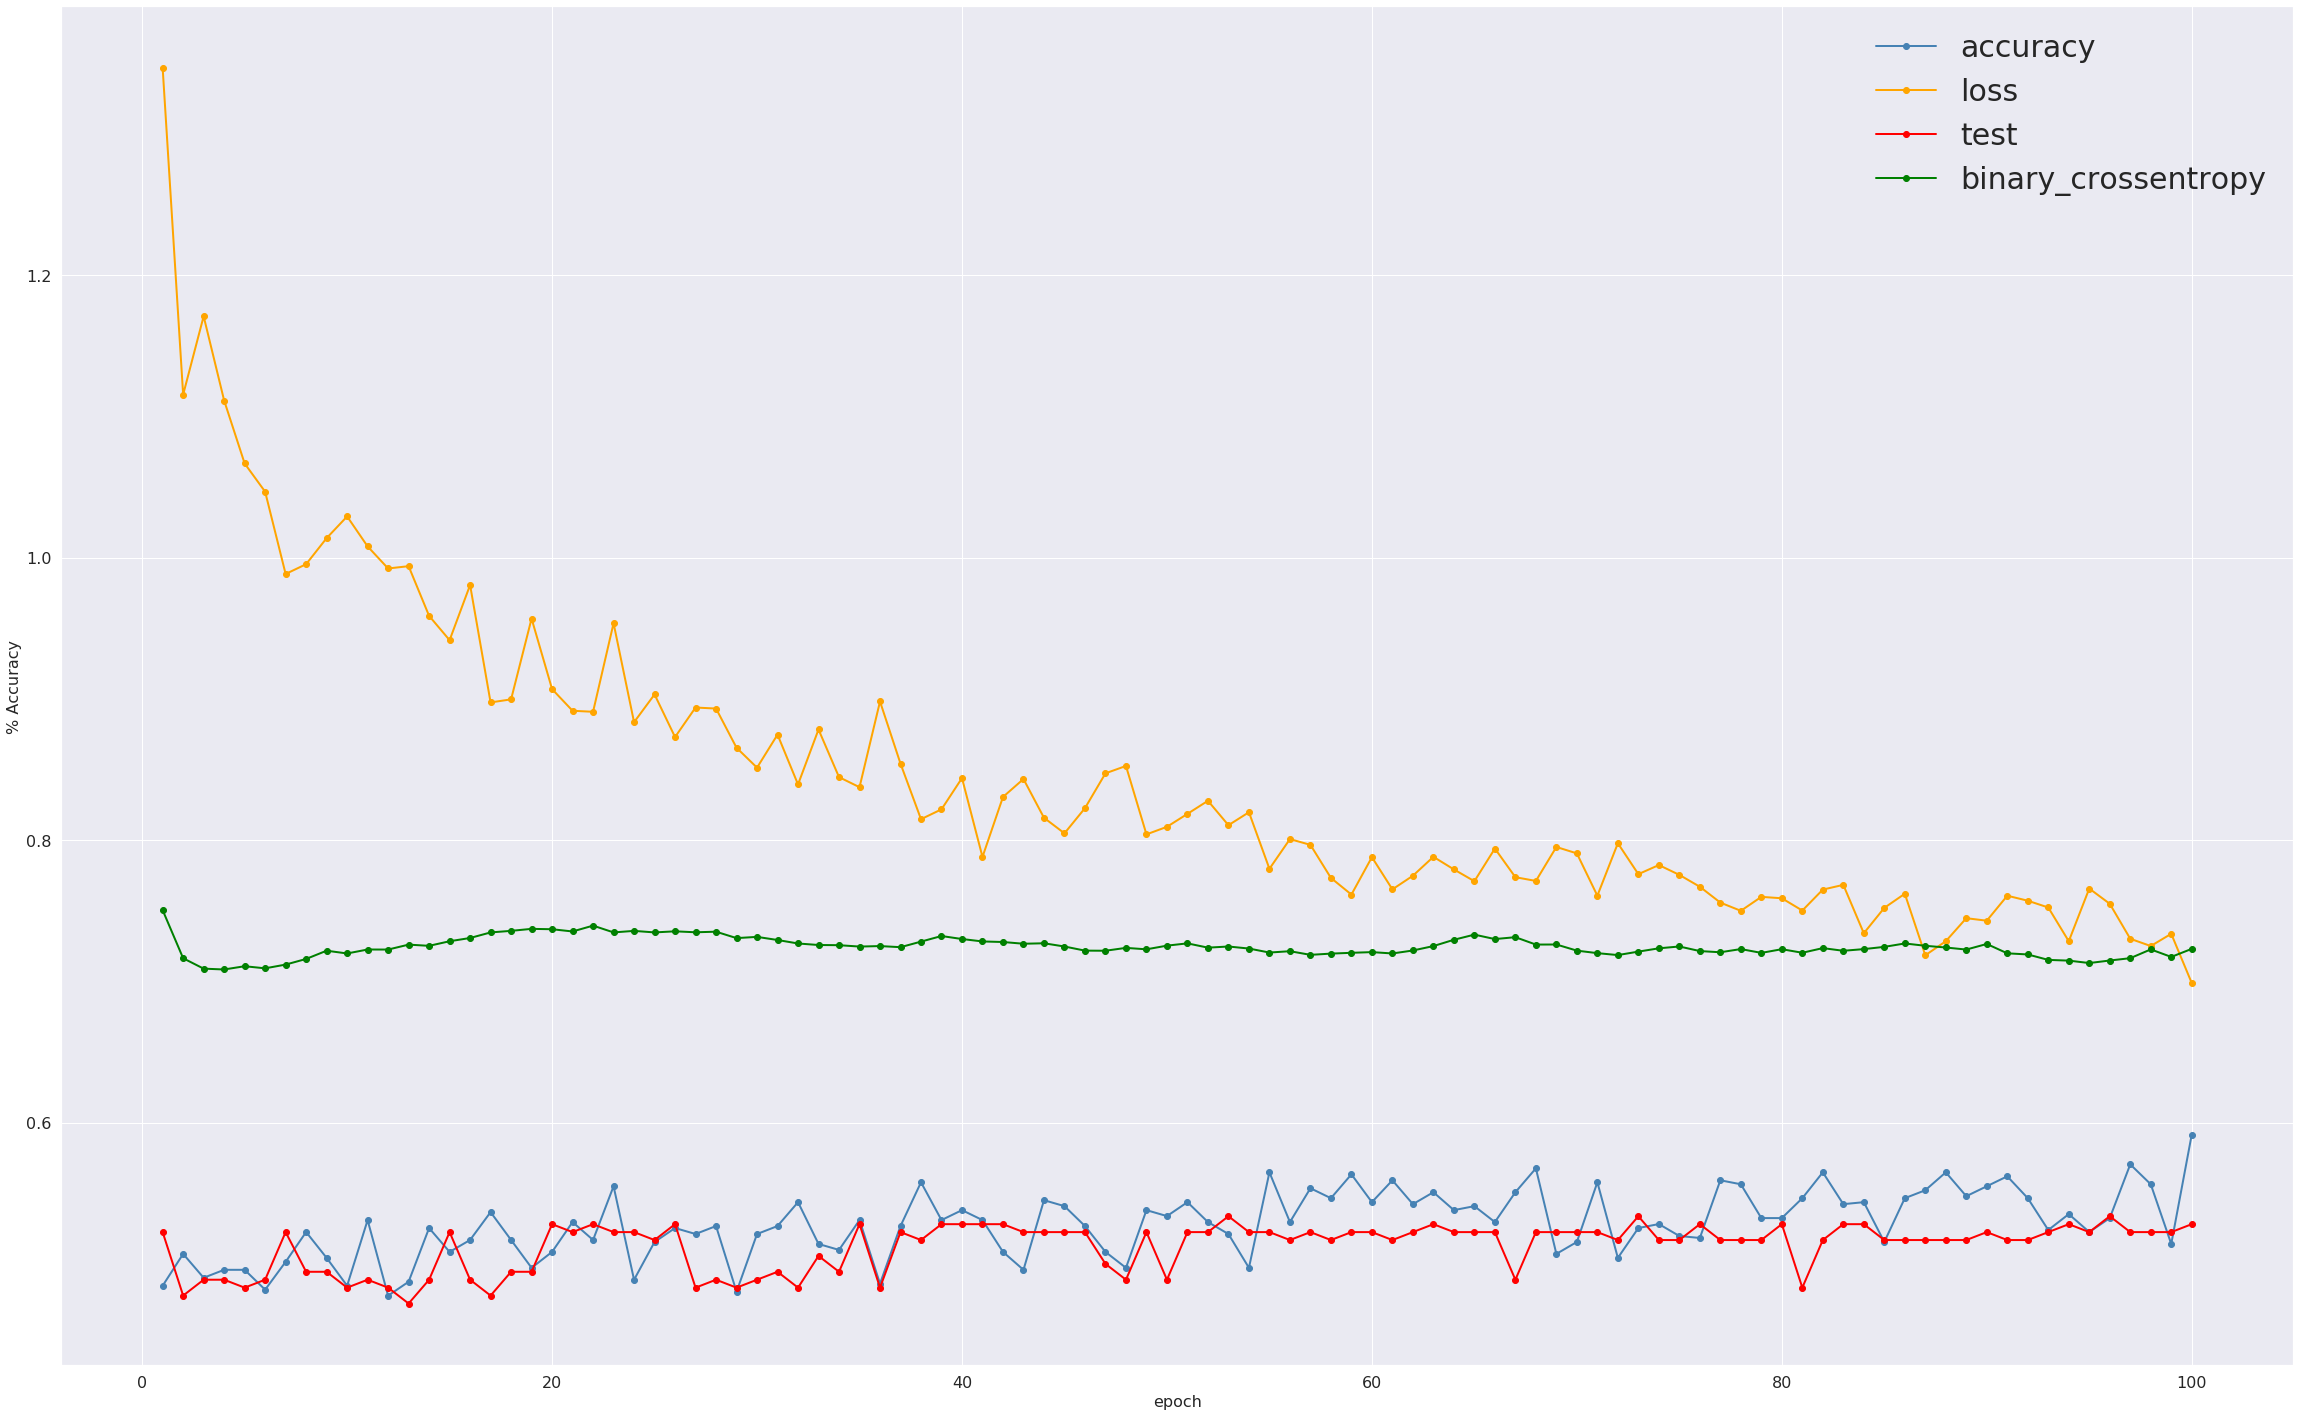

In [81]:
if run_3D_convnet:
    fig = plt.figure(figsize=(40, 25))
    epoch = np.arange(100) + 1
    fontsize = 16
    plt.plot(epoch, fit.history['accuracy'], marker="o", linewidth=2,
             color="steelblue", label="accuracy")
    plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
             color="orange", label="loss")
    plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2,
         color="red", label="test")
    plt.plot(epoch, fit.history['val_binary_crossentropy'], marker="o", linewidth=2,
         color="green", label="binary_crossentropy")
    plt.xlabel('epoch', fontsize=fontsize)
    plt.ylabel('% Accuracy', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(frameon=False, fontsize=30);

In [ ]:
# evaluate the model
scores = model.evaluate(testX, testY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


# PLOTTING

In [ ]:
SEQUENCES[20].shape

In [ ]:
plot_anat(BRAIN_BOXES[100], cmap='magma', colorbar=False, display_mode='ortho', annotate=False);

In [ ]:
B=nilearn.image.new_img_like(sequence_data,Rebounded_Sequence, affine=None, copy_header=False)

In [ ]:
plot_anat(BRAIN_BOXES[0], cmap='magma', colorbar=False, display_mode='ortho', annotate=False);

In [ ]:
A=nilearn.image.new_img_like(sequence_data, SEQUENCES[0], affine=None, copy_header=False)

In [ ]:
A.shape

In [ ]:


plot_anat(A, cmap='magma', colorbar=False, display_mode='ortho', annotate=False);



In [ ]:
plot_anat(sequence_data, cmap='magma', colorbar=False, display_mode='ortho', annotate=False);